## Protected Areas in the European Union ##

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

import xarray as xr
import atlite

import logging
import warnings

warnings.simplefilter('ignore')
logging.captureWarnings(False)
logging.basicConfig(level=logging.INFO)

import numpy as np
from shapely.geometry import Polygon


**Data source**:<br>
This data is from the EEA website
https://www.eea.europa.eu/data-and-maps/data/natura-14
<br> Click "GIS data" and then "Natura 2000 End 2021 - Shapefile" 
<br> Format: 3035

##### Sitetypes der NATURA 2000 Gebiete
pSCIs, SCIs, SACs and SPAs
Special Areas of Conservation, Special Protected Areas 

Special Protection
Areas (SPAs)
Sites of Community
Importance (SCIs)

Birds Directive Sites (SPA) Sitetype A  
Habitats Directive Sites (pSCI, SCI or SAC) Sitetype B und C

https://www.eea.europa.eu/data-and-maps/data/natura-14/natura-2000-tabular-data-12-tables/#HABITATS: info on the data set



In [3]:
#%%timeit -n 1 -r 1 #somehhow, timeits prevents the file from being completely read in
#takes 18 to 23 seconds
natura2000= gpd.read_file(r"..\data\Natura2000\Natura2000_end2021_rev1_epsg3035.shp")
natura2000.crs
n2000=natura2000.copy()
#the ETRS89 has its own CRS which does not use lat and lon 0-90 and 0-180
#according to Wikipedia, the WGS84 ellispoid and the GRS1980 ellipsoid are almost identical

In [4]:
n2000

,SITECODE,SITENAME,RELEASE_DA,MS,SITETYPE,INSPIRE_ID,geometry
0,PLH020044,Stawy Sobieszowskie,2022-01-30,PL,B,PL.ZIPOP.1393.N2K.PLH020044,"POLYGON ((4720229.316 3097165.865, 4720229.135..."
1,PLH020088,Dalkowskie Jary,2022-01-30,PL,B,PL.ZIPOP.1393.N2K.PLH020088,"POLYGON ((4727277.260 3188318.173, 4727332.740..."
2,PLH220055,Bunkier w Oliwie,2022-01-30,PL,B,PL.ZIPOP.1393.N2K.PLH220055,"POLYGON ((4874929.698 3510530.328, 4874912.582..."
3,PLH020051,Irysowy Zagon koło Gromadzynia,2022-01-30,PL,B,PL.ZIPOP.1393.N2K.PLH020051,"POLYGON ((4763482.469 3153897.167, 4763563.099..."
4,PLH020069,Las Pilczycki,2022-01-30,PL,B,PL.ZIPOP.1393.N2K.PLH020069,"POLYGON ((4806331.522 3139600.878, 4806378.028..."
...,...,...,...,...,...,...,...
27015,PLH020065,Bierutów,2022-01-30,PL,B,PL.ZIPOP.1393.N2K.PLH020065,"POLYGON ((4845506.878 3139563.939, 4845506.479..."
27016,PLH020013,Sztolnie w Leśnej,2022-01-30,PL,B,PL.ZIPOP.1393.N2K.PLH020013,"MULTIPOLYGON (((4691285.741 3115575.663, 46912..."
27017,PLH020020,Przełomy Pełcznicy pod Książem,2022-01-30,PL,B,PL.ZIPOP.1393.N2K.PLH020020,"POLYGON ((4763452.812 3100870.570, 4763456.427..."
27018,PLH020077,Żerkowice-Skała,2022-01-30,PL,B,PL.ZIPOP.1393.N2K.PLH020077,"MULTIPOLYGON (((4710563.262 3131459.217, 47107..."


In [6]:
n2000.info()
n2000['SITETYPE'].unique()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27020 entries, 0 to 27019
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SITECODE    27020 non-null  object  
 1   SITENAME    27020 non-null  object  
 2   RELEASE_DA  27020 non-null  object  
 3   MS          27020 non-null  object  
 4   SITETYPE    27020 non-null  object  
 5   INSPIRE_ID  7027 non-null   object  
 6   geometry    27020 non-null  geometry
dtypes: geometry(1), object(6)
memory usage: 1.4+ MB


array(['B', 'A', 'C'], dtype=object)

The limits are the resulting delimitations of the cutout.<br>
Result of cells.unary_union.bounds.Input coordinates of the cutout were farther apart.


In [10]:
limits= np.array([-4.375, 51.375, 10.125, 60.875])
xmin, xmax= (-4.375, 10.125)
ymin, ymax= (51.375, 60.875)
lat_point_list = [ymin, ymax, ymax,ymin,ymin]
lon_point_list = [xmin, xmin ,xmax ,xmax, xmin ]
original_polygon = Polygon(zip(lon_point_list, lat_point_list))
polygon = Polygon([original_polygon.boundary.interpolate(i, normalized=True) for i in np.linspace(0, 1, 10000)])
poly = gpd.GeoDataFrame(['Selection'], geometry=[polygon], crs=4326)
#poly.iloc[0].geometry.wkt



<AxesSubplot:>

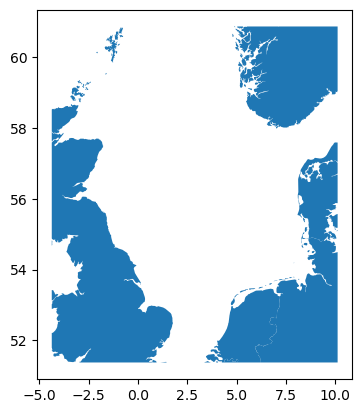

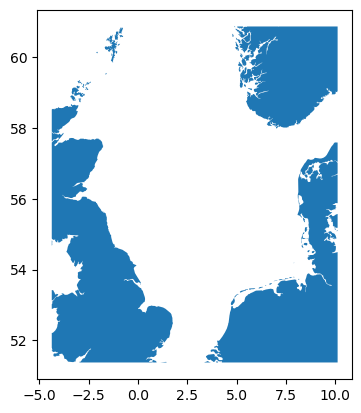

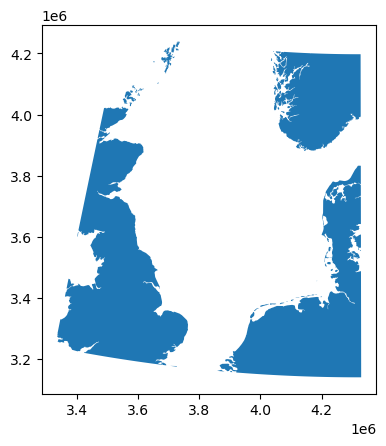

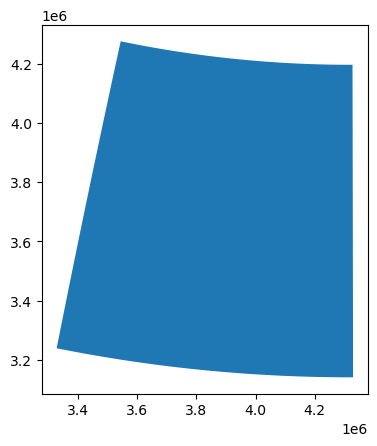

In [11]:
#hier Reduktion auf den Cutout-Ausschnitt mittels helper

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)

BorderingStates_init = gpd.GeoSeries({r.attributes['NAME_EN']: r.geometry
                      for r in reader.records()},
                     crs={'init': 'epsg:4326'}
                     ).reindex(['United Kingdom', 'Denmark','Germany','Norway','France','Netherlands','Belgium']) 

helper = gpd.GeoDataFrame(geometry=BorderingStates_init.geometry)#.reset_index().rename(columns={'index':'Countries'})#so kommt man zu Index
helper=helper.to_crs(4326) #komischerweise lässt sich das crs oben nicht übergeben
helper= helper.clip(poly)
helper.plot()
inland= helper.dissolve() #dissolve works only with GPDFs, unary_union returns a Multiploygon#coast0
inland.plot()
inland=inland.to_crs(3035)
inland.plot()
poly=poly.to_crs(3035)

poly.plot()
#poly.iloc[0].geometry.wkt ist sehr lang



In [13]:
#coast3= gpd.GeoDataFrame(["All countries"], geometry=coast2.geometry, crs=4326)
#coast3 = coast3.to_crs(3035)


n2000_1= n2000.clip(poly)
n2000_2 = n2000_1.overlay(inland, how='difference')



<AxesSubplot:>

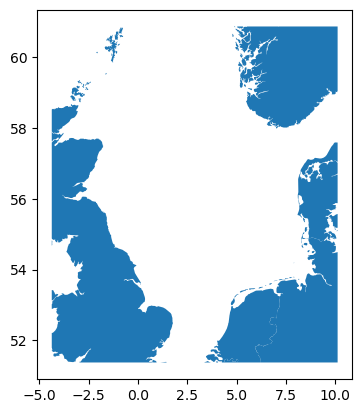

In [21]:
helper.plot()

<AxesSubplot:>

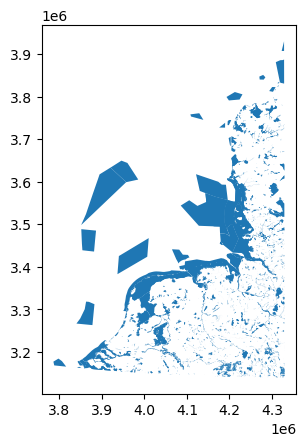

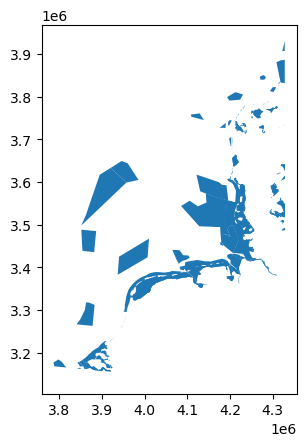

In [15]:
n2000_1.plot()
n2000_2.plot()

(2000000.0, 4500000.0)

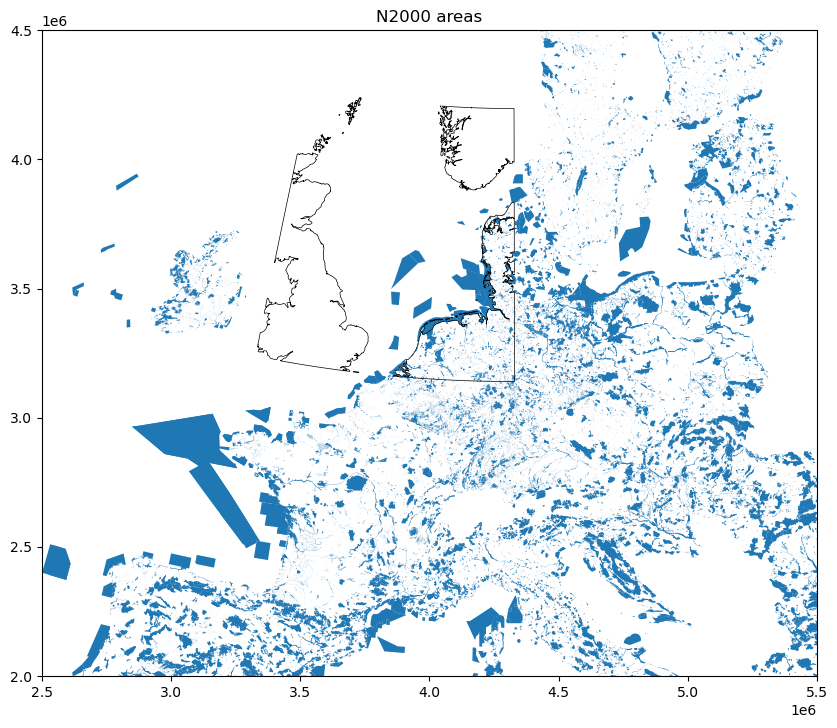

In [33]:
fig, ax =plt.subplots(1,1,figsize=(10,10))
n2000.plot(ax=ax)
#helper2 = gpd.GeoDataFrame(geometry=BorderingStates_init[3:7].geometry)
#helper2.plot(ax=ax,color='green')
ax.set_title("N2000 areas")
inland.to_crs(3035).boundary.plot(ax=ax,color='black',linewidth=0.5)
# otuher borders in the cutout are show,so: limit the axis
ax.set_xlim(2.5*10**6,5.5*10**6)
ax.set_ylim(2*10**6,4.5*10**6)
#

<AxesSubplot:title={'center':'N2000 areas in North East Europe in blue, Maritime N2000 areas in red, overlapping areas appear more red'}>

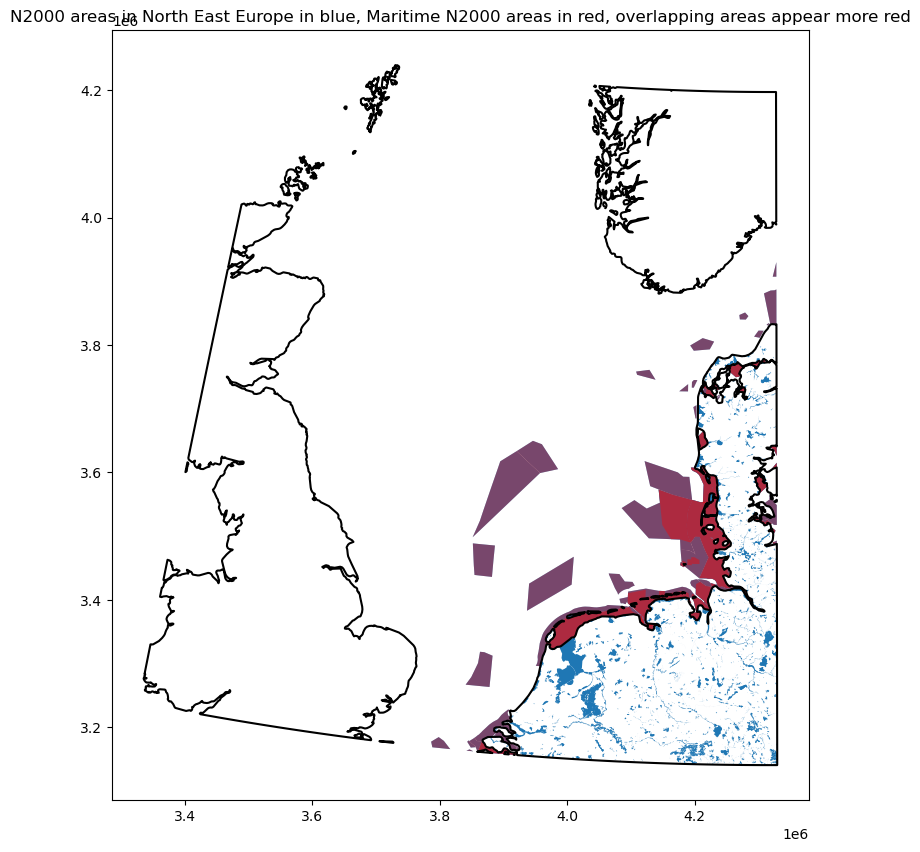

In [28]:
fig, ax =plt.subplots(1,1,figsize=(10,10))
ax.set_title("N2000 areas in North East Europe in blue, Maritime N2000 areas in red, overlapping areas appear more red")
n2000_1.plot(ax=ax)
inland.boundary.plot(color='black',ax=ax)
n2000_2.plot(ax=ax,color='red',zorder=1, alpha= 0.4)


In [29]:
n2000_2.columns

Index(['SITECODE', 'SITENAME', 'RELEASE_DA', 'MS', 'SITETYPE', 'INSPIRE_ID',
       'geometry'],
      dtype='object')

In [30]:
n2000_2.to_file(filename=r"..\data\protected_areas_shapefiles\protected_areas_N2000.gpkg", driver='GPKG')  

In [32]:
n2000_2.head()

,SITECODE,SITENAME,RELEASE_DA,MS,SITETYPE,INSPIRE_ID,geometry
0,DK00FX112,Skagens Gren og Skagerak,2018-02-02,DK,B,Dk.nst.ps.SAC1,"POLYGON ((4320593.965 3832468.028, 4320565.216..."
1,SE0520189,Bratten,2021-10-04,SE,B,SE.SWEPA.SE0520189,"POLYGON ((4322680.391 3907259.966, 4328306.871..."
2,DK00EX024,Hjarbæk Fjord og Simested Fjord,2018-02-02,DK,A,Dk.nst.ps.SPA24,"MULTIPOLYGON (((4275596.830 3721396.320, 42756..."
3,DK00EY134,"Lovns Bredning, Hjarbæk Fjord og Skals, Simest...",2018-02-02,DK,B,Dk.nst.ps.SAC30,"MULTIPOLYGON (((4279945.209 3715237.138, 42799..."
4,DK00DX319,Kastbjerg Ådal,2018-02-02,DK,B,Dk.nst.ps.SAC223,"MULTIPOLYGON (((4328678.017 3725585.935, 43286..."


## 